In [1]:
import numpy as np
import pandas as pd
import yfinance as yf

# ML libraries
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

import math
from datetime import date, datetime
import datetime as dtm

In [98]:
# Get stock quotes
tckr = "AAPL" # ticker
start = "2012-01-01"
end = "2023-07-01"
df = yf.download(tckr, start, end)
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,14.621429,14.732143,14.607143,14.686786,12.482927,302220800
2012-01-04,14.642857,14.810000,14.617143,14.765714,12.550010,260022000
2012-01-05,14.819643,14.948214,14.738214,14.929643,12.689340,271269600
2012-01-06,14.991786,15.098214,14.972143,15.085714,12.821993,318292800
2012-01-09,15.196429,15.276786,15.048214,15.061786,12.801655,394024400
...,...,...,...,...,...,...
2023-06-26,186.830002,188.050003,185.229996,185.270004,185.270004,48088700
2023-06-27,185.889999,188.389999,185.669998,188.059998,188.059998,50730800
2023-06-28,187.929993,189.899994,187.600006,189.250000,189.250000,51216800


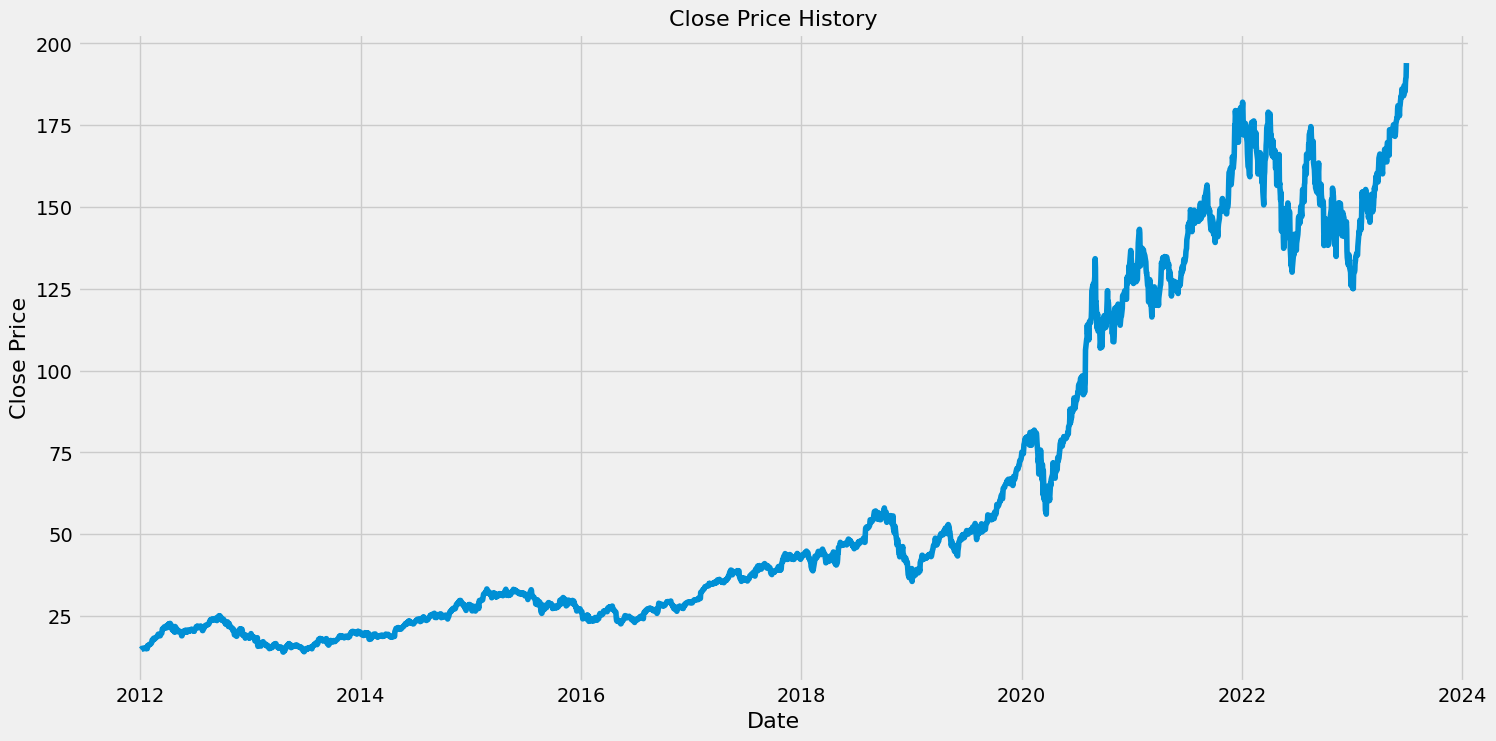

In [99]:
plt.figure(figsize=(16,8))
plt.title("Close Price History", fontsize=16)
plt.plot(df.Close)
plt.xlabel("Date", fontsize=16)
plt.ylabel("Close Price", fontsize=16)
plt.show()

In [122]:
# New dataframe with only close column
data = df.filter(["Close"])
# Convert the dataframe into a numpy array
dataset = data.values

In [123]:
# Get length of training and testing data
training_data_len = math.ceil(len(dataset) * 0.8)
test_data_len = len(dataset) - training_data_len
print(training_data_len, test_data_len)

2314 578


In [124]:
# Scale down data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.00410663],
       [0.00454506],
       [0.00545566],
       ...,
       [0.97378105],
       [0.97566968],
       [1.        ]])

In [125]:
# Testing dataset
test_data = scaled_data[training_data_len - 60: , :]

x_test = []
y_test = dataset[training_data_len:, :]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60: i, 0])

# Convert to numpy arrays
x_test = np.array(x_test)

In [126]:
# Reshape to 3D format
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_test.shape

(578, 60, 1)

In [127]:
# Load Saved Model
from keras.models import load_model
model = load_model("us_lstm_model2")

In [128]:
# Get the models predicted values
predictions = model.predict(x_test)
# Scale down data
predictions = scaler.inverse_transform(predictions)

19/19 [==============================] - 0s 5ms/step


In [129]:
# Evaluate Model
# Get RMSE - root mean square error
# The closer the number to zero, the closer the predicted values to original values,
#  the better it was predicting 
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

0.5660054559938635

/var/folders/4f/xy4jvtjs1qg16v7xbbpgsc840000gn/T/ipykernel_60269/1099830945.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid["Predictions"] = predictions


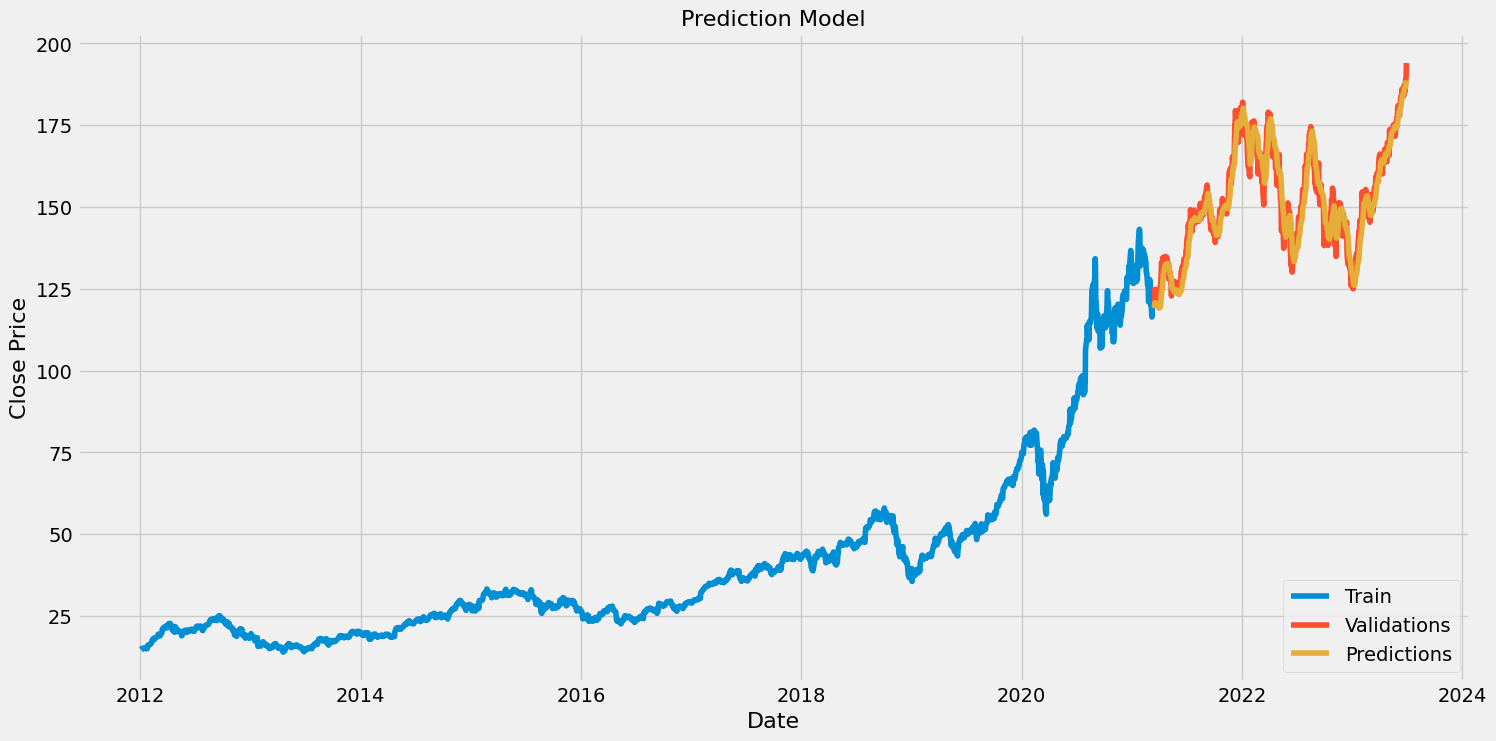

In [130]:
# Plot data
train = data[0: training_data_len] # from zero
valid = data[training_data_len:] # validation data
valid["Predictions"] = predictions

# Visualise data
plt.figure(figsize=(16,8))
plt.title("Prediction Model", fontsize=16)
plt.xlabel("Date", fontsize=16)
plt.ylabel("Close Price", fontsize=16)
plt.plot(train.Close)
plt.plot(valid[["Close", "Predictions"]])
plt.legend(["Train", "Validations", "Predictions"], loc="lower right")
plt.show()

In [131]:
# Show valid and predicted
valid

,Close,Predictions
Date,,
2021-03-16,125.570000,119.087700
2021-03-17,124.760002,119.914398
2021-03-18,120.529999,120.695213
2021-03-19,119.989998,120.769836
2021-03-22,123.389999,120.432861
...,...,...
2023-06-26,185.270004,186.505875
2023-06-27,188.059998,186.757492
2023-06-28,189.250000,187.241974


In [132]:
# Predict for the next n_days => n_days can be 10, 20, 30, 60, 100 days e.t.c
n_days = 10
# Create new dataframe
new_df = df.filter(["Close"])

# Combined dataframe: Contains original close prices and predicted prices
combined = new_df

data = {
    "Date": [],
    "Close": []
}
next_n_days = pd.DataFrame(data)
next_n_days.set_index('Date', inplace=True)

last_day = dtm.datetime.strptime(end, "%Y-%m-%d")
last_day = last_day - dtm.timedelta(days=1)
last_day = last_day.strftime("%Y-%m-%d")
last_day = dtm.datetime.strptime(last_day, "%Y-%m-%d")

for i in range(n_days):
    # Get the last 100 days closing price and convert dataframe to an array
    last_n_days = combined[-100:].values
    # Scale down data
    last_n_days_scaled = scaler.transform(last_n_days)
    X_test = []
    X_test.append(last_n_days_scaled)
    # Convert to numpy arrays
    X_test = np.array(X_test)
    # Reshape to 3D format
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    # Predicted price
    pred_price = model.predict(X_test)
    # Scale up
    pred_price = scaler.inverse_transform(pred_price)
    
    #. Update dataframe with predicted value
    tomorrow = last_day + dtm.timedelta(days=1)
    # tomorrow = tomorrow.strftime("%Y-%m-%d")
    new_row = {
        "Date": [tomorrow],
        "Close": [pred_price[0].tolist()[0]]
    }
    last_day = tomorrow
    # last_day = dtm.datetime.strptime(last_day, "%Y-%m-%d")
    
    next_day = pd.DataFrame(new_row)
    next_day.set_index('Date', inplace=True)
    next_n_days = pd.concat([next_n_days, next_day])
    combined = pd.concat([combined, next_day])

1/1 [==============================] - 0s 12ms/step


In [133]:
new_df

,Close
Date,
2012-01-03,14.686786
2012-01-04,14.765714
2012-01-05,14.929643
2012-01-06,15.085714
2012-01-09,15.061786
...,...
2023-06-26,185.270004
2023-06-27,188.059998
2023-06-28,189.250000


In [134]:
next_n_days

,Close
Date,
2023-07-01,189.876770
2023-07-02,190.622269
2023-07-03,191.168945
2023-07-04,191.620789
2023-07-05,192.028625
2023-07-06,192.416840
2023-07-07,192.797028
2023-07-08,193.174591
2023-07-09,193.551926


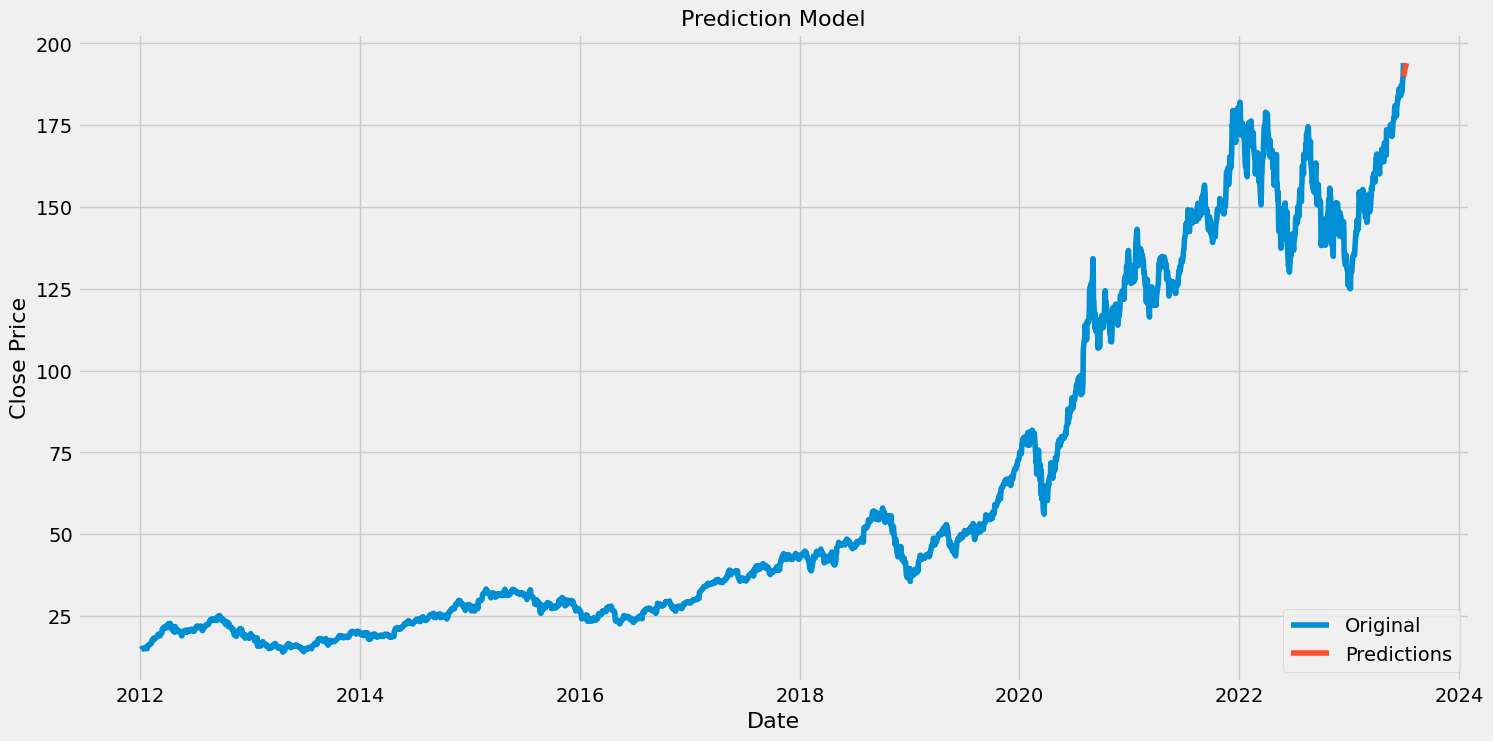

In [135]:
# Visualise data
plt.figure(figsize=(16,8))
plt.title("Prediction Model", fontsize=16)
plt.xlabel("Date", fontsize=16)
plt.ylabel("Close Price", fontsize=16)
plt.plot(new_df.Close)
plt.plot(next_n_days.Close)
plt.legend(["Original", "Predictions"], loc="lower right")
plt.show()

In [136]:
# Show previous 3 months plus n_days (10, 30, 60 e.t.c) predictions 
prev_days = 90;
prev_n_days = new_df[-prev_days:]
prev_n_days.tail()

,Close
Date,
2023-06-26,185.270004
2023-06-27,188.059998
2023-06-28,189.250000
2023-06-29,189.589996
2023-06-30,193.970001


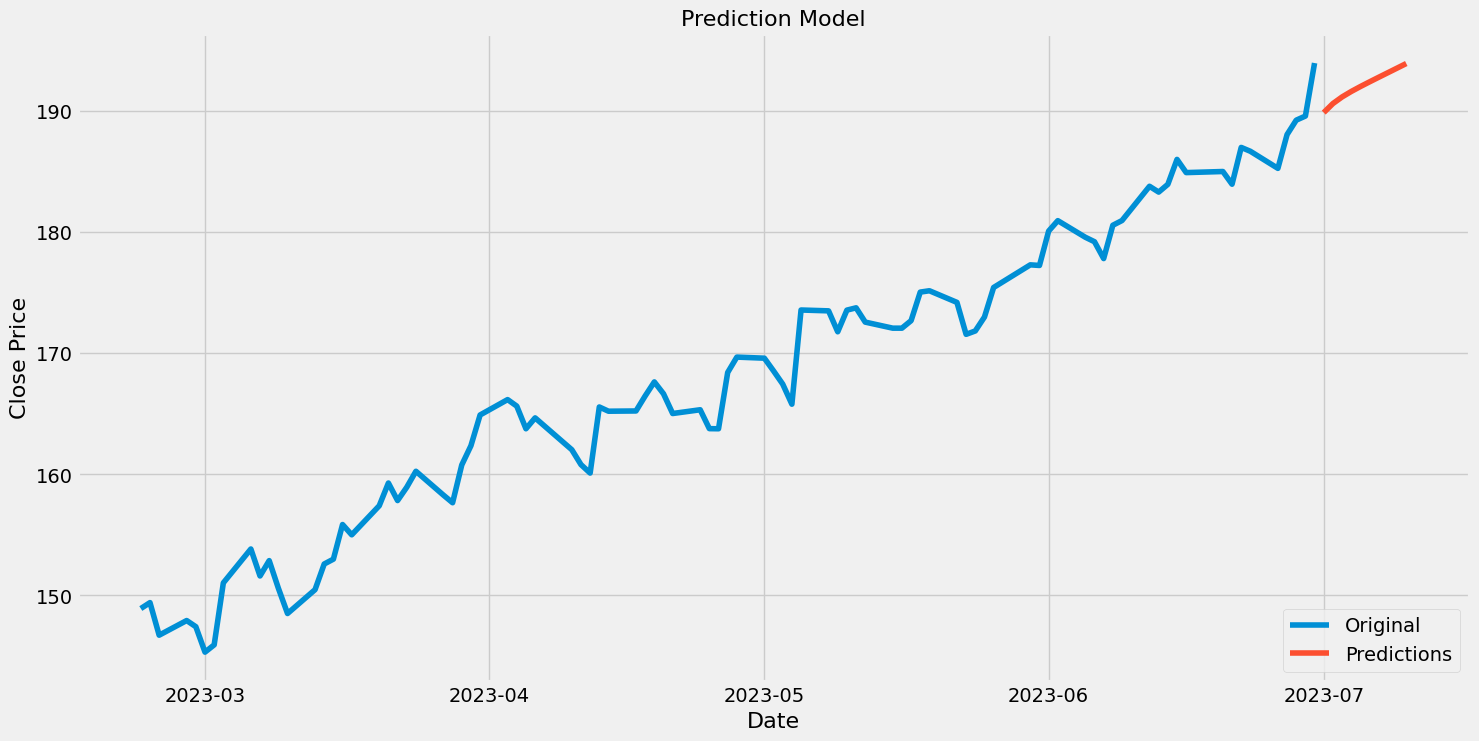

In [137]:
# Visualise data for previous 3 months
plt.figure(figsize=(16,8))
plt.title("Prediction Model", fontsize=16)
plt.xlabel("Date", fontsize=16)
plt.ylabel("Close Price", fontsize=16)
plt.plot(prev_n_days.Close)
plt.plot(next_n_days.Close)
plt.legend(["Original", "Predictions"], loc="lower right")
plt.show()

In [138]:
# OPTIONAL
# Campare predicted closing price as shown in red graph above and actual closing prices
new_end_date = dtm.datetime.strptime(end, "%Y-%m-%d")
new_end_date = new_end_date + dtm.timedelta(days=n_days)
new_end_date = new_end_date.strftime("%Y-%m-%d")
actual_quote = yf.download(tckr, start, new_end_date)
actual_quote

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,14.621429,14.732143,14.607143,14.686786,12.482929,302220800
2012-01-04,14.642857,14.810000,14.617143,14.765714,12.550010,260022000
2012-01-05,14.819643,14.948214,14.738214,14.929643,12.689340,271269600
2012-01-06,14.991786,15.098214,14.972143,15.085714,12.821992,318292800
2012-01-09,15.196429,15.276786,15.048214,15.061786,12.801655,394024400
...,...,...,...,...,...,...
2023-07-03,193.779999,193.880005,191.759995,192.460007,192.460007,31458200
2023-07-05,191.570007,192.979996,190.619995,191.330002,191.330002,46920300
2023-07-06,189.839996,192.020004,189.199997,191.809998,191.809998,45094300


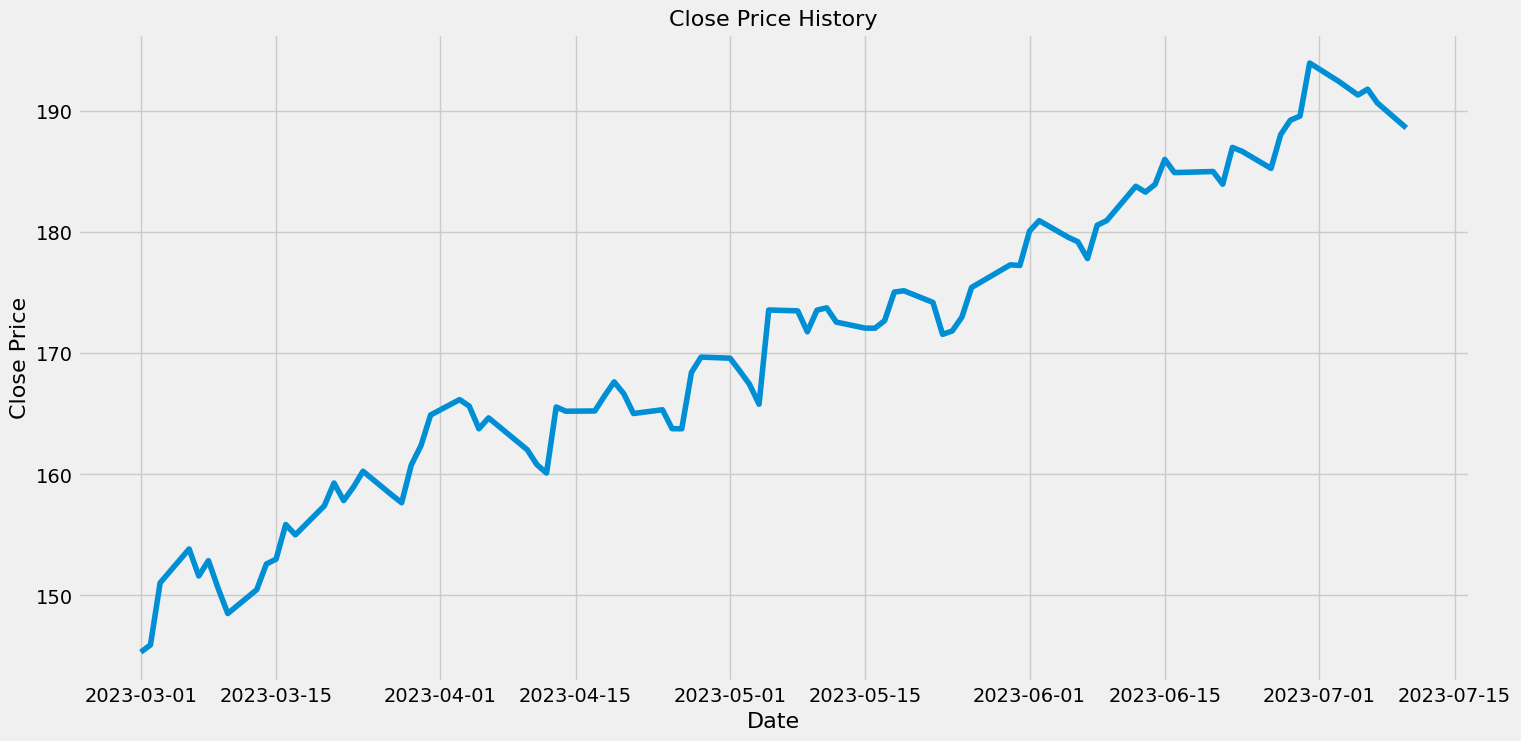

In [139]:
# Visualise actual quote
actual_quote = actual_quote[-prev_days:] # Show only prev 90 days of actual quote
plt.figure(figsize=(16,8))
plt.title("Close Price History", fontsize=16)
plt.plot(actual_quote.Close)
plt.xlabel("Date", fontsize=16)
plt.ylabel("Close Price", fontsize=16)
plt.show()